In [14]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from sklearn.metrics import mean_absolute_error

In [15]:
df = pd.read_csv('petr4_treinamento.csv')
df = df.dropna()
train_df = df.iloc[:, 1:7].values

In [16]:
normalizer = MinMaxScaler()

train_df_norm = normalizer.fit_transform(train_df)

In [17]:
X = []
y = []

for i in range(90, 1242):
    X.append(train_df_norm[i-90:i, 0:6])
    y.append(train_df_norm[i, 0])


X = np.array(X)
y = np.array(y)

In [18]:
X = torch.tensor(X, dtype = torch.float32)
y = torch.tensor(y, dtype = torch.float32)

In [19]:
dataset = torch.utils.data.TensorDataset(X, y)
loader = torch.utils.data.DataLoader(dataset, batch_size = 32, shuffle = True)

In [20]:
class regressor_LSTM(nn.Module):
    def __init__(self):
        super().__init__()

        self.lstm1 = nn.LSTM(input_size=6, hidden_size=100)
        self.lstm2 = nn.LSTM(100, 50)
        self.lstm3 = nn.LSTM(50, 50, dropout=0.3, num_layers=2)

        self.dropout = nn.Dropout(0.3)

        self.linear = nn.Linear(in_features=50, out_features=1)

        self.sigmoid = nn.Sigmoid()

    def forward(self, X):
        X = X.permute(1, 0, 2)

        X, _ = self.lstm1(X)

        X = self.dropout(X)

        X, _ = self.lstm2(X)

        X = self.dropout(X)

        X, _ = self.lstm3(X)

        X = self.dropout(X)

        X = X[-1]
        X = self.dropout(X)

        X = self.linear(X)

        X = self.sigmoid(X)

        return X

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [22]:
regressor = regressor_LSTM().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(regressor.parameters(), lr=0.001)

In [23]:
ES_MIN_DELTA = 1e-10
ES_PATIENCE = 10
RLR_FACTOR = 0.2
RLR_PATIENCE = 5

min_loss = np.inf

In [24]:
for epoch in range(200):
    running_loss = 0.
    running_mae = 0.

    for i, data in enumerate(loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = regressor(inputs)
        outputs = outputs.flatten()

        loss = criterion(outputs, labels)
        loss.backward()

        optimizer.step()

        running_loss += loss.item()
        mae = mean_absolute_error(labels.detach().cpu().numpy().flatten(), outputs.detach().cpu().numpy().flatten())

        running_mae += mae

        print(f'Epoch {epoch+1}, Loss: {running_loss/len(loader)}, MAE: {running_mae/len(loader)}')

    running_loss /= len(loader)
    running_mae /= len(loader)

    print(f'Epoch {epoch+1}, Loss: {running_loss}, MAE: {running_mae}')

    if running_loss < min_loss:
        print(f'**Cost function reduced from {min_loss} to {running_loss}**')
        torch.save(regressor.state_dict(), 'model.pth')
        min_loss = running_loss
        es_patience = 0
        rlr_patience = 0

    else:
        print("**Cost does not decrease**")

        if running_loss - min_loss >= ES_MIN_DELTA:
            es_patience += 1
            if es_patience >= ES_PATIENCE:
                print(f'Early stopping at epoch {epoch+1}')
                break

        rlr_patience += 1
        if rlr_patience == RLR_PATIENCE:
            print('-- Criterion of learning rate reduced achieved, reducing LR. --')

            for param_group in optimizer.param_groups:
                param_group['lr'] *= RLR_FACTOR

            rlr_patience = 0


Epoch 1, Loss: 0.0015058407766951455, MAE: 0.005273770954873826
Epoch 1, Loss: 0.0027582847202817598, MAE: 0.010428043703238169
Epoch 1, Loss: 0.003902044561174181, MAE: 0.014895968553092744
Epoch 1, Loss: 0.005163525748584006, MAE: 0.020233280542824004
Epoch 1, Loss: 0.006158328822089566, MAE: 0.02436438451210658
Epoch 1, Loss: 0.00689068033049504, MAE: 0.027912537670797773
Epoch 1, Loss: 0.007986255921423435, MAE: 0.03262146148416731
Epoch 1, Loss: 0.008608751619855562, MAE: 0.036010866777764425
Epoch 1, Loss: 0.009480558853182528, MAE: 0.03973362884587712
Epoch 1, Loss: 0.01076357201155689, MAE: 0.044744583053721323
Epoch 1, Loss: 0.01182291636036502, MAE: 0.04917257817255126
Epoch 1, Loss: 0.01275038118991587, MAE: 0.053090246187316045
Epoch 1, Loss: 0.013913618504173227, MAE: 0.05808741350968679
Epoch 1, Loss: 0.014751919286532534, MAE: 0.06198211510976156
Epoch 1, Loss: 0.015622635320242908, MAE: 0.06591014522645208
Epoch 1, Loss: 0.016443882861899004, MAE: 0.0699542723596096
Epo

In [26]:
test_df = pd.read_csv('petr4_teste.csv')
real_price_test = test_df.iloc[:, 1:2].values
all_df = pd.concat([df, test_df])

In [27]:
all_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-01-02,19.990000,20.209999,19.690001,19.690001,18.086271,30182600.0
1,2013-01-03,19.809999,20.400000,19.700001,20.400000,18.738441,30552600.0
2,2013-01-04,20.330000,20.620001,20.170000,20.430000,18.766001,36141000.0
3,2013-01-07,20.480000,20.670000,19.950001,20.080000,18.444506,28069600.0
4,2013-01-08,20.110001,20.230000,19.459999,19.500000,17.911745,29091300.0


In [29]:
all_df = all_df.drop(columns=['Date'], axis=1)

In [30]:
entry = all_df[len(all_df) - len(test_df) - 90:].values
entry = normalizer.transform(entry)

In [31]:
X_test = []

for i in range(90, 112):
    X_test.append(entry[i-90:i, 0:6])


X_test = np.array(X_test)

In [32]:
X_test = torch.tensor(X_test, device=device, dtype=torch.float32)

In [33]:
regressor.eval()
forecast = regressor(X_test)
regressor = forecast.detach().cpu().numpy().reshape(-1, 1)

In [34]:
normalizer_forecast = MinMaxScaler(feature_range=(0, 1))
normalizer_forecast.fit(train_df[:, 0:1])

MinMaxScaler()

In [35]:
forecast = normalizer_forecast.inverse_transform(regressor)

In [36]:
forecast

array([[16.129488],
       [16.299221],
       [16.548088],
       [16.798452],
       [16.91869 ],
       [16.98245 ],
       [17.04096 ],
       [16.982515],
       [17.032206],
       [17.169163],
       [17.322336],
       [17.519089],
       [17.96132 ],
       [18.308693],
       [18.415545],
       [18.406828],
       [18.299175],
       [18.635298],
       [19.147633],
       [19.59974 ],
       [19.8569  ],
       [19.779163]], dtype=float32)

In [37]:
forecast.mean()

17.77968

In [39]:
real_price_test.mean()

17.87454563636364

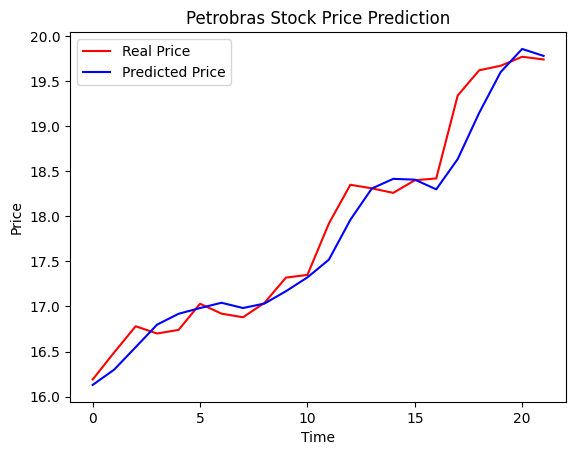

In [41]:
plt.plot(real_price_test, color='red', label='Real Price')
plt.plot(forecast, color='blue', label='Predicted Price')
plt.title('Petrobras Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()